In [758]:
import numpy as np
import skimage
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage.feature import canny
from skimage import filters
from skimage import segmentation
from skimage import data, exposure
from skimage.exposure import histogram
from skimage.feature import match_template
from skimage.transform import rescale
from skimage.util import random_noise
from scipy.signal import correlate2d
from skimage import io
from skimage.transform import resize

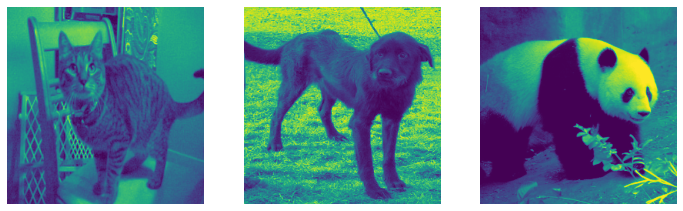

In [759]:
pixelsPerCells = (8,8)
size = 256

cats = [resize(io.imread(f"animals/cats/cats_" + f"{idx:05d}" + ".jpg", as_gray=True), (size, size)) for idx in range(1,49)]
dogs = [resize(io.imread(f"animals/dogs/dogs_"+ f"{idx:05d}" + ".jpg", as_gray=True), (size, size)) for idx in range(1,49)]
pandas = [resize(io.imread(f"animals/pandas/panda_" + f"{idx:05d}" + ".jpg", as_gray=True), (size, size)) for idx in range(1,49)]
images = cats + dogs + pandas

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axes[0].imshow(cats[0]) and axes[0].axis('off')
axes[1].imshow(dogs[0]) and axes[1].axis('off')
axes[2].imshow(pandas[0]) and axes[2].axis('off')

plt.show()

In [760]:

cats_hog = [hog(img, orientations=8, pixels_per_cell=pixelsPerCells,
                    cells_per_block=(1, 1)) for img in cats]
dogs_hog = [hog(img, orientations=8, pixels_per_cell=pixelsPerCells,
                    cells_per_block=(1, 1)) for img in dogs]
pandas_hog = [hog(img, orientations=8, pixels_per_cell=pixelsPerCells,
                    cells_per_block=(1, 1)) for img in pandas]

cats_canny = [canny(resize(io.imread(f"animals/cats/cats_" + f"{idx:05d}" + ".jpg", as_gray=True), (size, size)), sigma=2, low_threshold=0.1, high_threshold=0.3) for idx in range(1,20)]
dogs_canny = [canny(resize(io.imread(f"animals/dogs/dogs_"+ f"{idx:05d}" + ".jpg", as_gray=True), (size, size)), sigma=2, low_threshold=0.1, high_threshold=0.3) for idx in range(1,20)]
pandas_canny = [canny(resize(io.imread(f"animals/pandas/panda_" + f"{idx:05d}" + ".jpg", as_gray=True), (size, size)), sigma=2, low_threshold=0.1, high_threshold=0.3) for idx in range(1,20)]

# # étiquettes (1 pour les vélos, 2 pour les voitures)
# cats_labels = 1 * np.ones((len(cats_hog), ))
# dogs_labels = 2 * np.ones((len(dogs_hog), ))
# pandas_labels = 3 * np.ones((len(pandas_hog), ))

# étiquettes (1 pour les vélos, 2 pour les voitures)
cats_labels = 1 * np.ones((len(cats_canny), ))
dogs_labels = 2 * np.ones((len(dogs_canny), ))
pandas_labels = 3 * np.ones((len(pandas_canny), ))

# dataset = np.concatenate((cats_hog, dogs_hog, pandas_hog))
dataset = np.concatenate((cats_canny, dogs_canny, pandas_canny))

labels = np.concatenate((cats_labels, dogs_labels, pandas_labels)).astype("int")
print(labels.shape)

(57,)


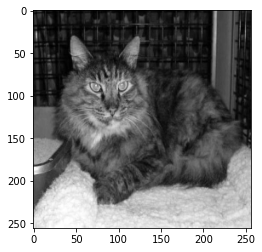

In [761]:
query = resize(io.imread("animals/cats/cats_" + f"{48:05d}" + ".jpg", as_gray=True), (size, size))
plt.imshow(query, cmap="gray") and plt.show()

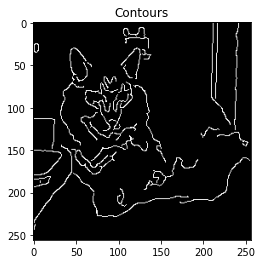

In [762]:
edges = canny(query, sigma=2, low_threshold=0.1, high_threshold=0.3)
plt.imshow(edges, cmap="gray")
plt.title("Contours")
plt.show()

In [763]:
# hog_query = hog(query, orientations=8, pixels_per_cell=pixelsPerCells, cells_per_block=(1, 1))
hog_query = hog(edges, orientations=8, pixels_per_cell=pixelsPerCells, cells_per_block=(1, 1))

scores = np.array([])
for egdes_animal in dataset:
  # img = io.imread(animal)
  
  # edges_img = canny(animal, sigma=2, low_threshold=0.1, high_threshold=0.3)
  # hog_img = hog(edges_img, orientations=8, pixels_per_cell=pixelsPerCells, cells_per_block=(1, 1))

  hog_edges = hog(egdes_animal, orientations=8, pixels_per_cell=pixelsPerCells, cells_per_block=(1, 1))

  scores = np.append(scores, [np.linalg.norm(hog_query - hog_edges)])

closest = np.argsort(scores)
print(closest)
fig, axes = plt.subplots(nrows=1, ncols=len(closest), figsize=(20, 8))
for idx, img_idx in enumerate(closest):
  axes[idx].imshow(images[img_idx], cmap="gray") and axes[idx].axis('off')

k = 10
closest_labels = labels[closest[:k]]
print(f"Étiquettes des {k} images les plus proches : {closest_labels}")
print(f"Étiquette majoritaire : {np.argmax(np.bincount(closest_labels))}")

if (np.argmax(np.bincount(closest_labels)) == 1):
  print(f"C'est un chat")
elif (np.argmax(np.bincount(closest_labels)) == 2):
  print(f"C'est un chien")
elif (np.argmax(np.bincount(closest_labels)) == 3):
  print(f"C'est un panda")

[13 18 26  7  3  4 12 24 48 28 10 22 33 17  5  8 16 14 32  0  2 15 27 31
 51 25 34 39  1 37 38 52  6 35 21  9 30 47 20 29 45 11 19 55 36 41 43 50
 42 49 56 23 53 54 40 46 44]
Étiquettes des 10 images les plus proches : [1 1 2 1 1 1 1 2 3 2]
Étiquette majoritaire : 1
C'est un chat


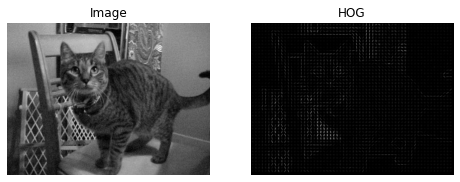

In [764]:
image = io.imread(f"animals/cats/cats_" + f"{1:05d}" + ".jpg", as_gray=True)

descriptor, hog_image = hog(image, orientations=8, pixels_per_cell=pixelsPerCells,
                    cells_per_block=(1, 1), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap="gray") and ax1.set_title("Image")

# Amélioration du contraste
hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image, cmap="gray") and ax2.set_title("HOG")
plt.show()

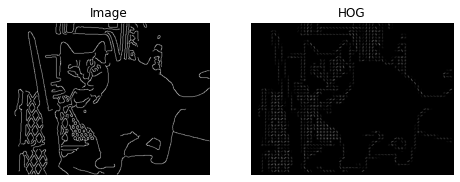

In [765]:
cannyCat = canny(image, sigma=2, low_threshold=0.1, high_threshold=0.3)

descriptor, hog_image = hog(cannyCat, orientations=8, pixels_per_cell=pixelsPerCells,
                    cells_per_block=(1, 1), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(cannyCat, cmap="gray") and ax1.set_title("Image")

# Amélioration du contraste
hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image, cmap="gray") and ax2.set_title("HOG")
plt.show()

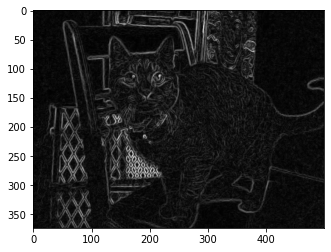

In [766]:
elevation_map = filters.sobel(image)
plt.imshow(elevation_map, cmap="gray") and plt.show()

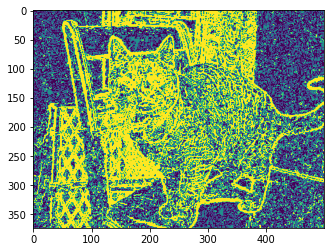

In [767]:
markers = np.zeros_like(elevation_map)
markers[elevation_map < np.percentile(elevation_map, 10)] = 1
markers[elevation_map > np.percentile(elevation_map, 50)] = 2
plt.imshow(markers) and plt.show()

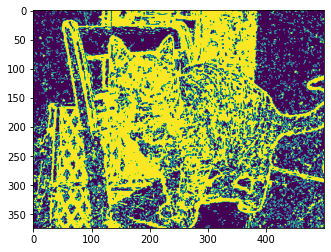

In [768]:
regions = segmentation.watershed(elevation_map, markers)
plt.imshow(regions) and plt.show()

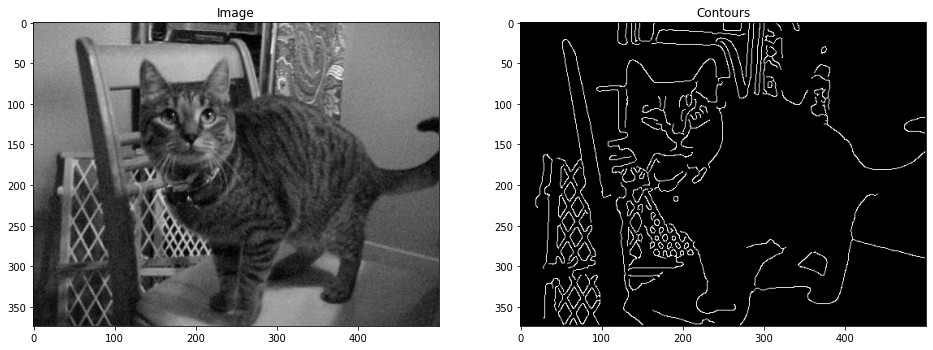

In [769]:
chat1 = io.imread(f"animals/cats/cats_" + f"{1:05d}" + ".jpg", as_gray=True)

edges = canny(chat1, sigma=2, low_threshold=0.1, high_threshold=0.3)

fig = plt.figure(figsize=(16, 8))
fig.add_subplot(121)
plt.imshow(chat1, cmap="gray")
plt.title("Image")
fig.add_subplot(122)
plt.imshow(edges, cmap="gray")
plt.title("Contours")
plt.show()